In [2]:
import pandas as pd
import os
import urllib.request
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

In [8]:
#load the csv file that is extracted by the help of above function
def load_data(data_path, data_name):
    csv_path = os.path.join(data_path, data_name)
    return pd.read_csv(csv_path)

#get path of this notebook and join /Downloads to it
path = os.path.join(os.getcwd(),"Downloads")

#get y_train from X_train
X_train = load_data(path, 'train.csv')
y_train = X_train['Survived']
#X_train = X_train.drop('Survived', axis=1) do it later

#We don't have given y_test, instead will submit our predictions on Kaggle 
X_test = load_data(path, 'test.csv')

In [10]:
#Define functions for visualisation
plt.rcParams.update({'figure.figsize':(20,16), 'figure.dpi':100})

#for sns.countplot percentage prints
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

#function for plotting
def matrix_countplot(data, main, group, percent=False, diagonal = False):
    #main = x-axis, always rearrage as len(groups)>len(main) if not switch names
    if len(group) < len(main):
        tmp = main
        main = group
        group = tmp
    
    len_main = len(main)
    len_group = len(group)
    
    #define subplot dims    
    fig, ax = plt.subplots(int(len(main)), int(len(group)))

    x_main = np.repeat(list(range(len_main)), len_group)
    y_group = list(range(len_group))*len_main
    main_augmented = np.repeat(main, len_group)
    group_augmented = group*len_main
    
    if (len_main == 1):
        x_main = list(range(len_group))
        
        for ix, g in zip(x_main, group):
            ax_c = sns.countplot(data = data, x = main[0], hue = g, ax = ax[ix])
            percentage_above_bar_relative_to_xgroup(ax_c)
        
    else:
        for ix, iy, m, g in zip(x_main, y_group, main_augmented, group_augmented):
            ax_c = sns.countplot(data = data, x = m, hue = g, ax = ax[ix][iy])
        
            if percent:
                percentage_above_bar_relative_to_xgroup(ax_c)
        
            else:
            
                if ((len(data[m].unique())>3) | (len(data[g].unique())>3)):
                    continue
                else:
                    percentage_above_bar_relative_to_xgroup(ax_c)
                    
        if (len_main == len_group) & (len_main > 1) & (diagonal == False):
        
            for i in range(len_main): #Get rid of the diagonal duplicates
                ax[i][i].set_visible(False)

            
    return plt.show()

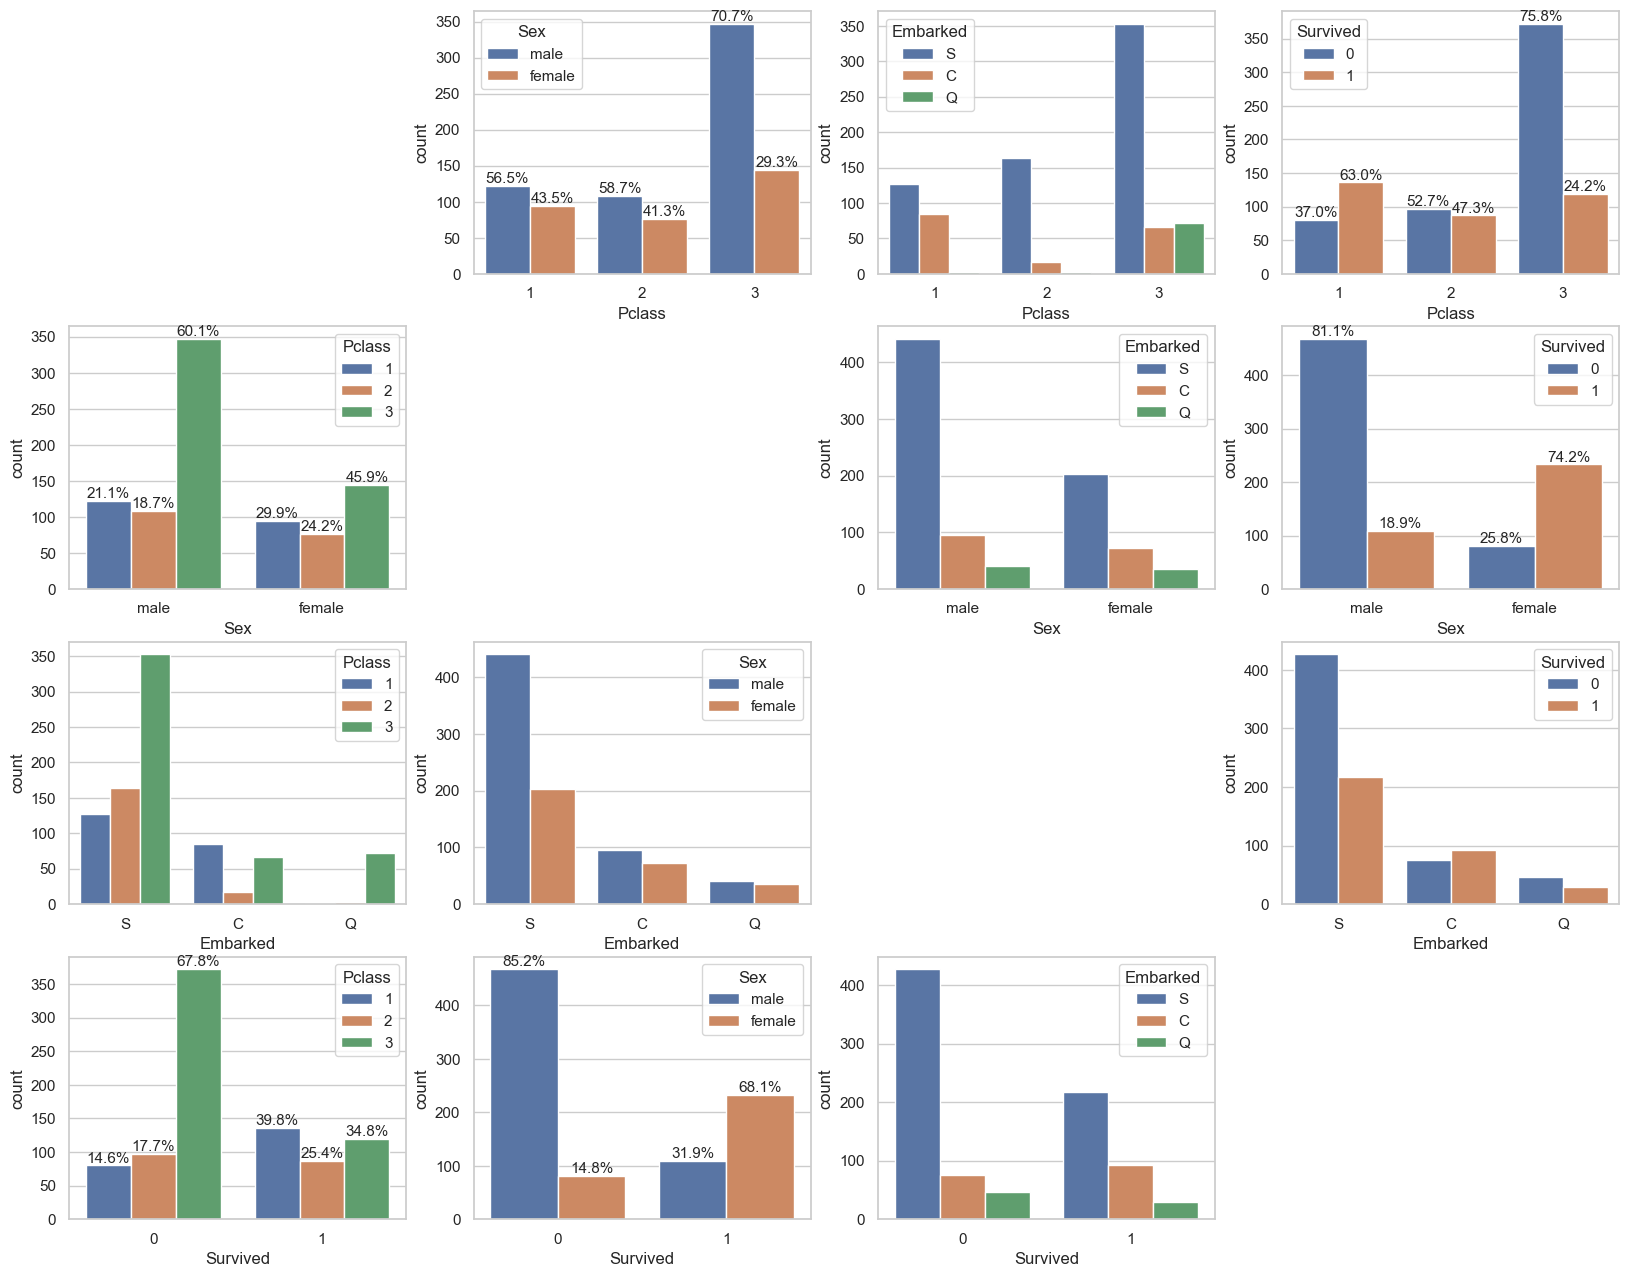

In [11]:
cat_features = ['Pclass','Sex','Embarked','Survived']
matrix_countplot(X_train, cat_features, cat_features, percent = False, diagonal = False)

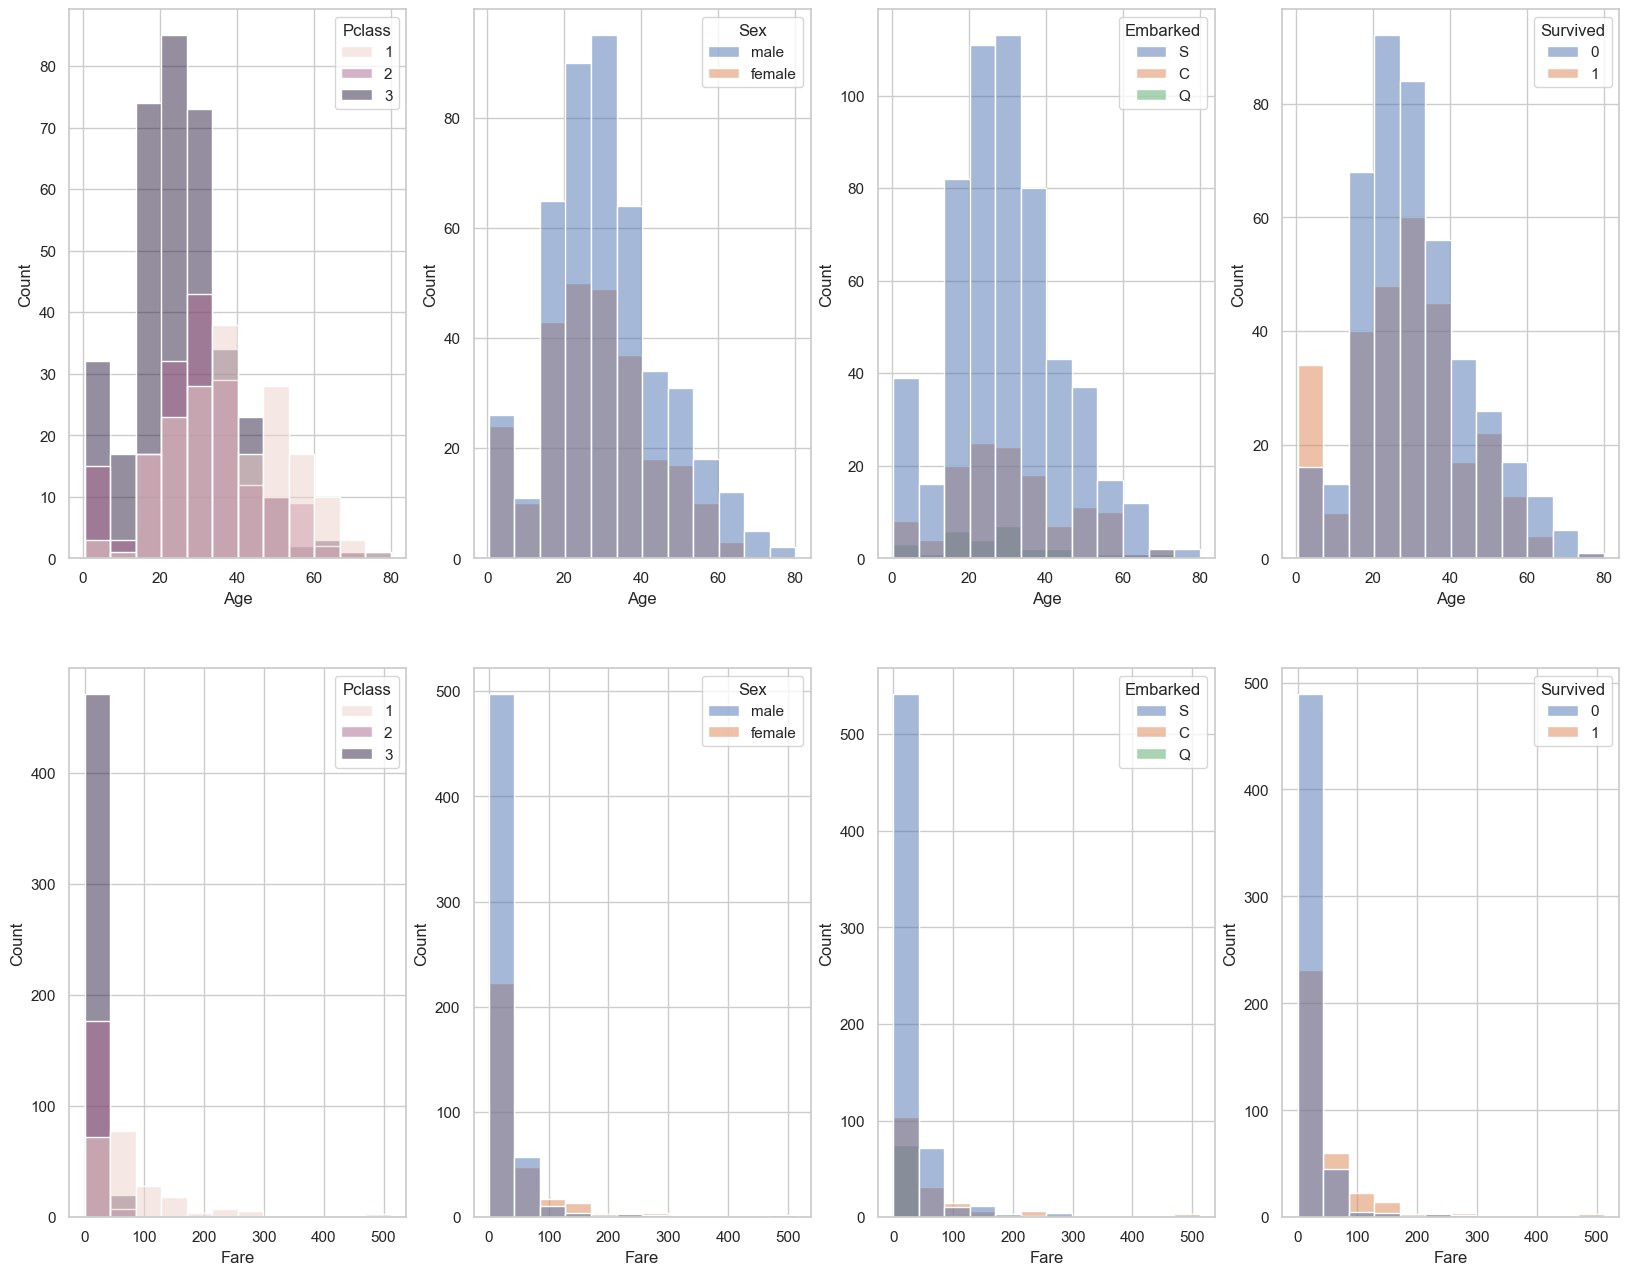

In [12]:
#Num features Age and Fare
plt.rcParams.update({'figure.figsize':(20,16), 'figure.dpi':100})

#def cat_features
num_features = ['Age','Fare']


fig, ax = plt.subplots(len(num_features), int(len(cat_features)))

x = list(np.repeat(list(range(len(num_features))),len(cat_features)))
y = list(range(len(cat_features)))*len(cat_features)


num_columns = list(np.repeat(num_features,len(cat_features)))

#do it manually no function is defined for continous values
for ix, iy, num_cat, cat in zip(x, y, num_columns, cat_features*2):
        sns.histplot(x = X_train[num_cat], ax = ax[ix][iy], hue = X_train[cat], bins=12)
        

plt.show()

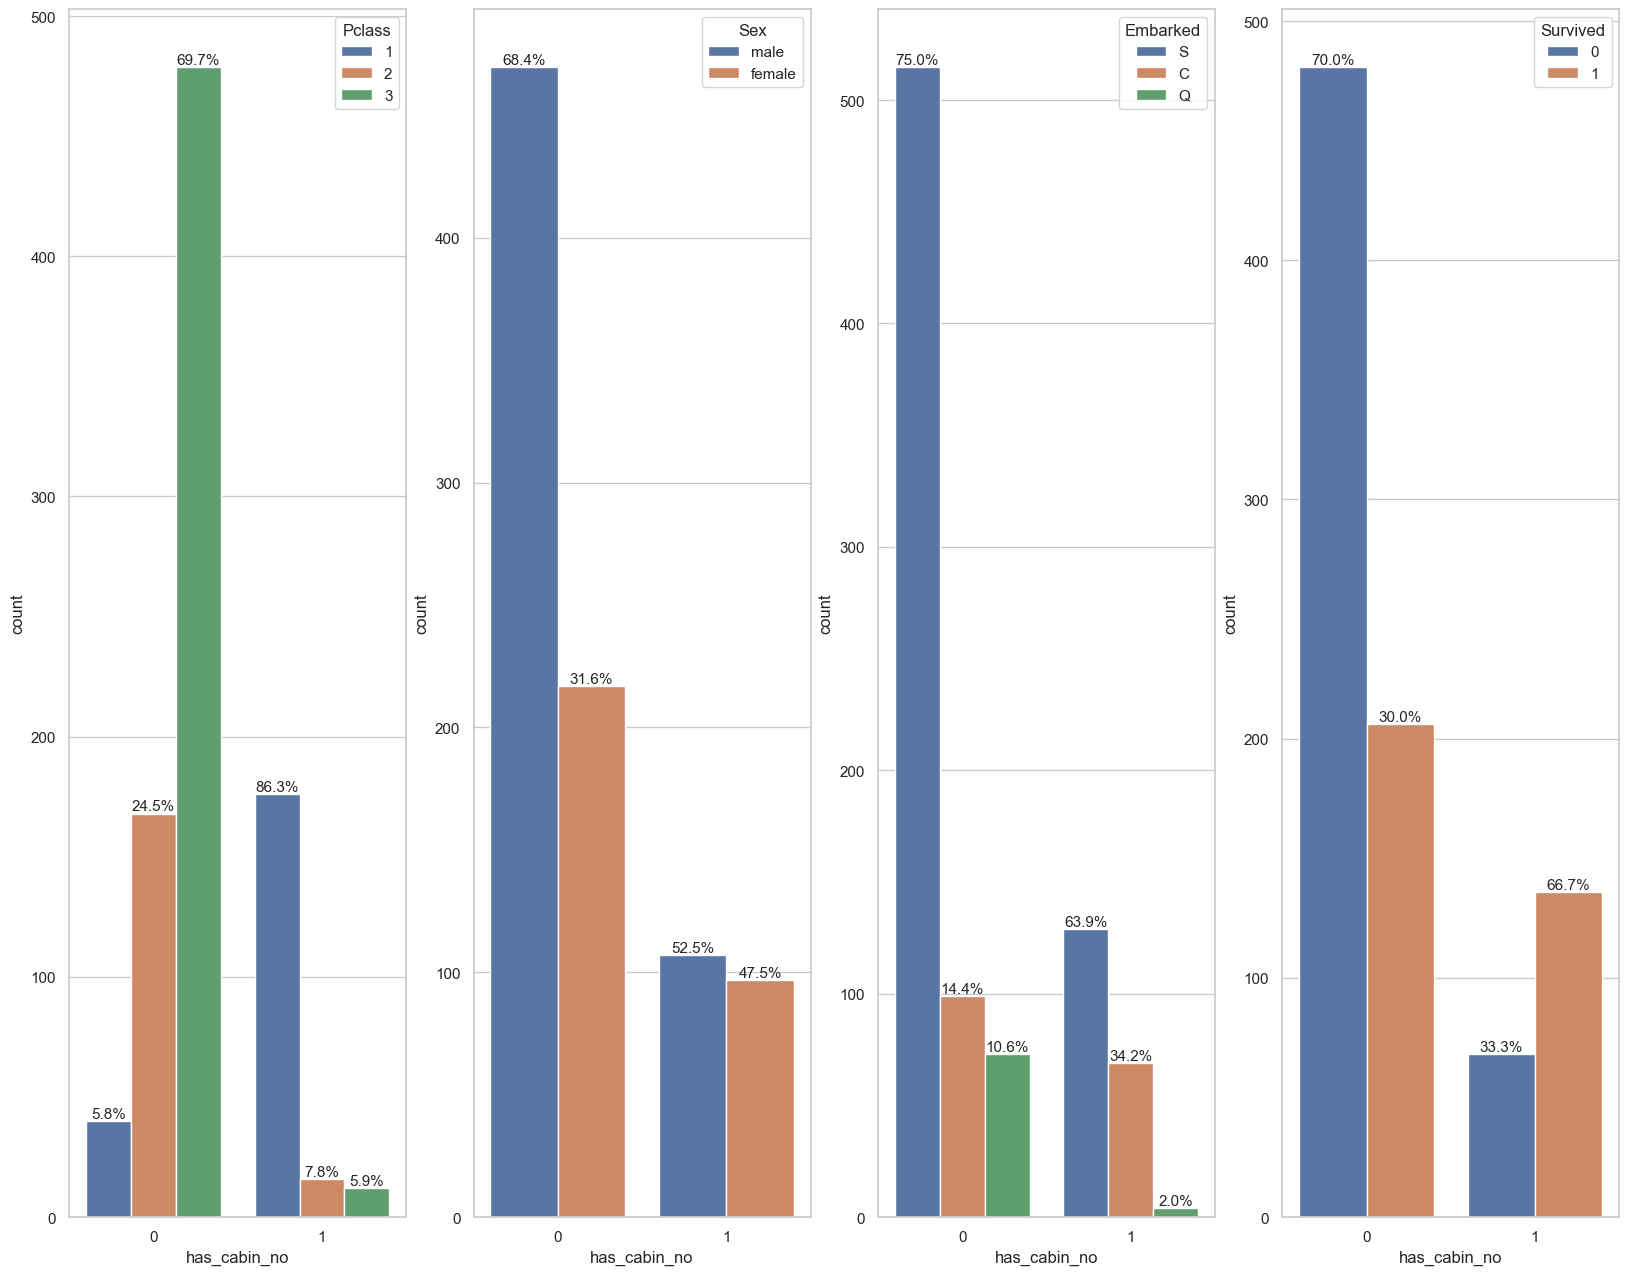

In [13]:
#Feature Engineering 
def Categorize_Cabin(X):
    X = X.astype(str)
    return np.where(X=='nan', 0, 1)

#Have a cabin no?   
X_train['has_cabin_no'] = Categorize_Cabin(X_train['Cabin'])

# Family Size
X_train['FamilySize'] = X_train['SibSp'] + X_train['Parch'] + 1

# Is Alone?
X_train['IsAlone'] = 0
X_train.loc[X_train['FamilySize'] == 1, 'IsAlone'] = 1

# Title
X_train['Title']=X_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
X_train['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                         ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
                         inplace=True)

#plot Cabin vs all cat features
matrix_countplot(X_train, ['has_cabin_no'], cat_features, percent = False, diagonal = False)


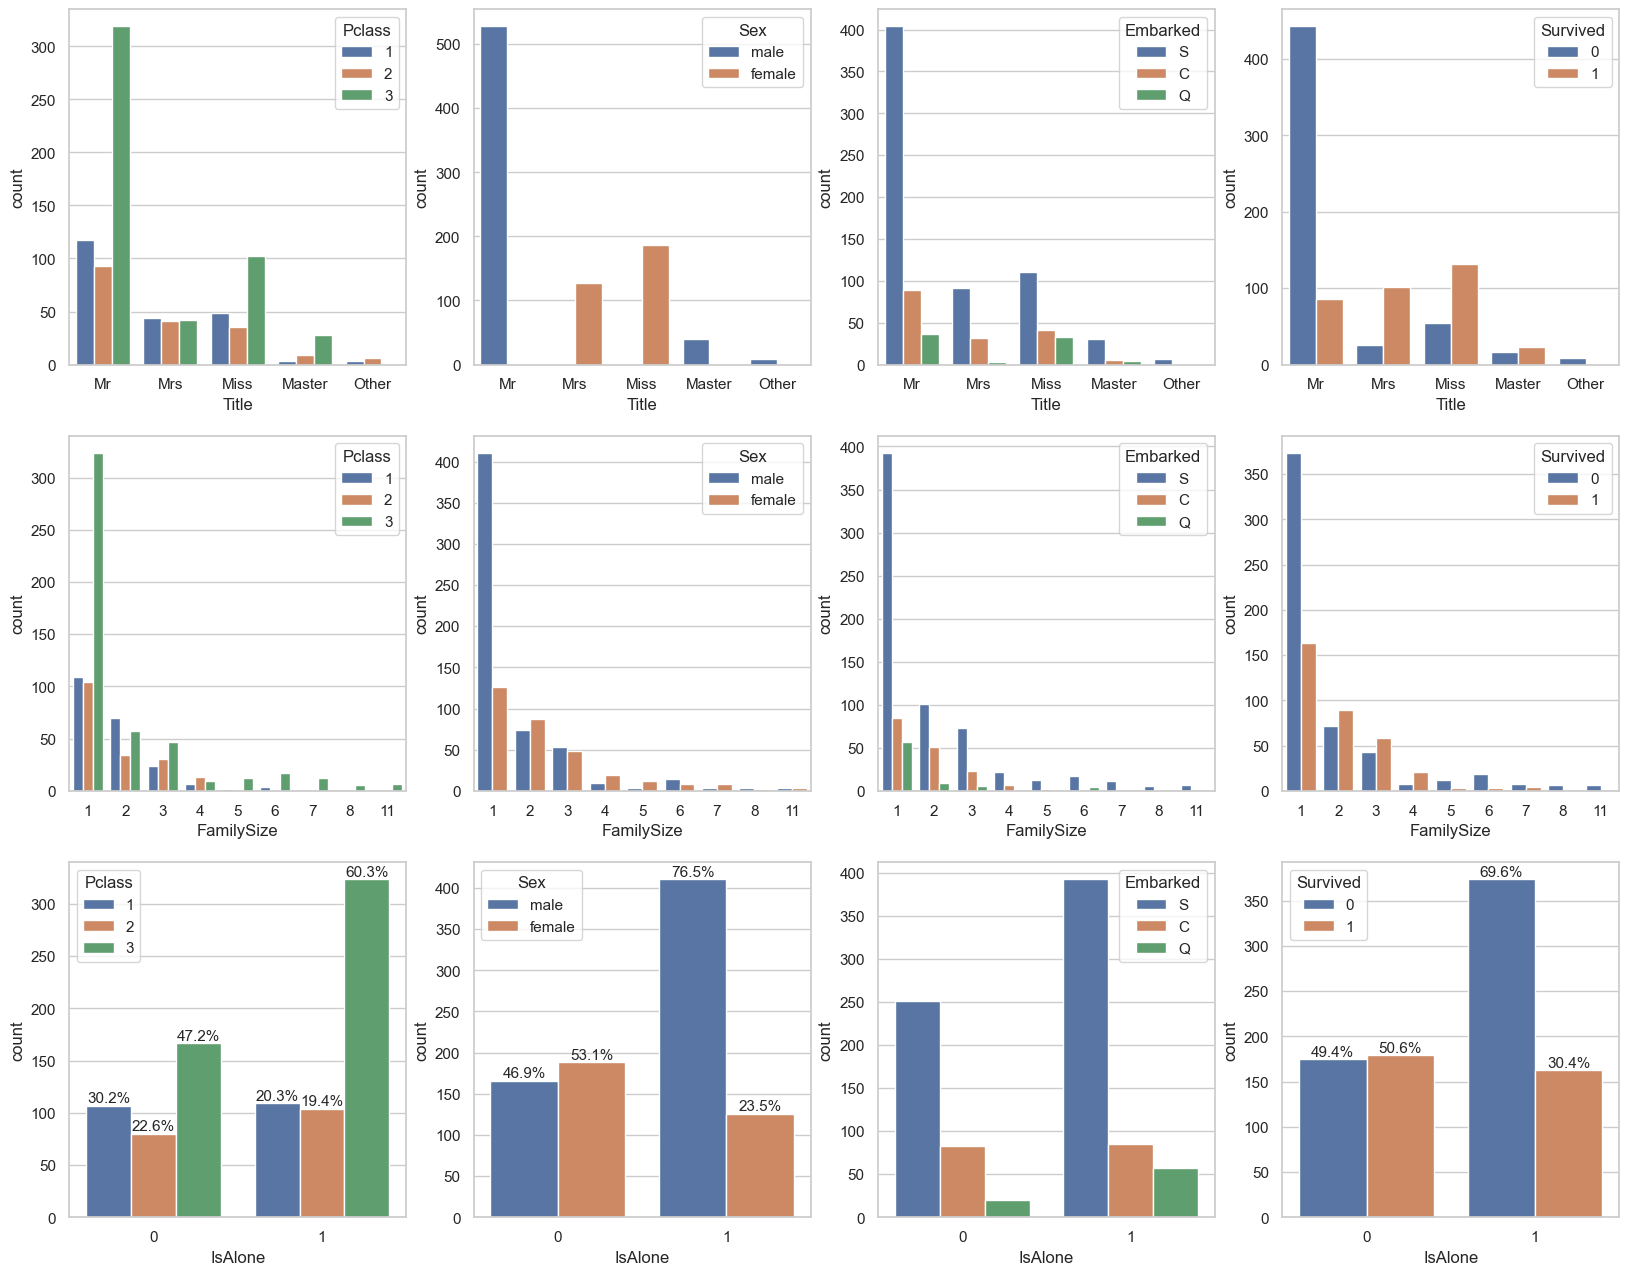

In [14]:
cat_features2 = ['Title','FamilySize','IsAlone']
matrix_countplot(X_train, cat_features2, cat_features, percent = False, diagonal = False)

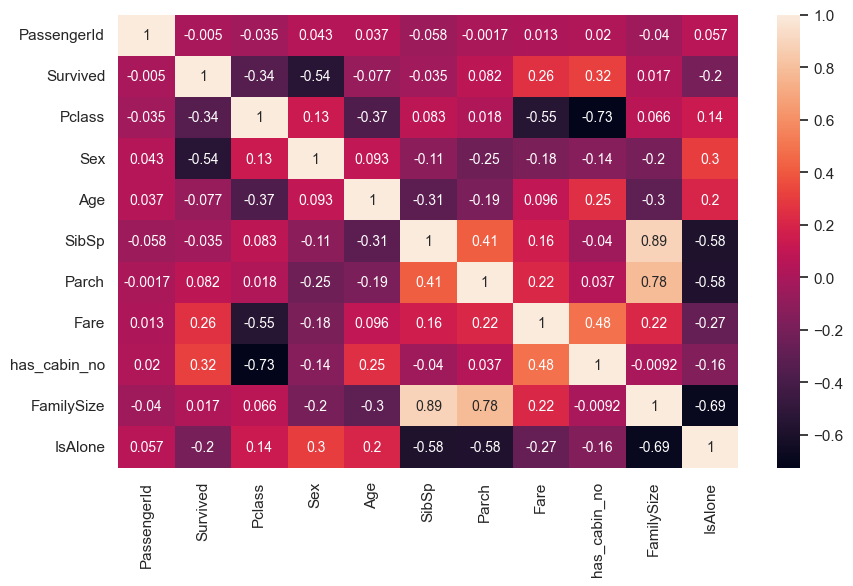

In [15]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100})

X_train['Sex'] = pd.DataFrame(np.where(X_train['Sex']=='male',1,0), columns=['Sex'])
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()